# Project Notebook - Team 6
Overview... #TODO

### Team Members
* Victoria Dorn
* Stephen Farmer
* Andrew Fennimore

[Link to GitHub Project Repo](https://github.com/vdorn5/aai-511-final-project)

In [50]:
# Capturing the libraries that are necessary for running the following notebook

# Data Pre-processing
import kagglehub
import os
import zipfile
import mido
import numpy as np
import pandas as pd
from collections import Counter
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil
import glob
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Modeling
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Data Ingest (Extract)
#TODO


In [51]:
# Downloading the dataset from Kagglehub
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
print(f"Path: {path}")

Path: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1


In [52]:
# Extracting the folders we need from the zip file
zip_path = os.path.join(path, "midiclassics.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(path)

In [53]:
# Looking for composers
composer_paths = {}
composers = ['Mozart', 'Chopin', 'Bach', 'Beethoven']

for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for composer in composers:
            if composer.lower() in item.lower():
                composer_paths[composer] = item_path
                print(f"{composer}: {item_path}")

Bach: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/Bach
Beethoven: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/Beethoven
Mozart: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/Mozart
Chopin: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/Chopin


In [54]:
# Collecting all the files for each composer, including in subfolder
def collect_composer_files(base_path, composers=composers):
    composer_files = {composer: [] for composer in composers}
    
    for root, dirs, files in os.walk(base_path):
        current_dir = os.path.basename(root).lower()
        for composer in composers:
            if composer.lower() in current_dir:
                # Collect MIDI files from this directory
                midi_files = [os.path.join(root, f) for f in files] 
                composer_files[composer].extend(midi_files)
                break  
    
    return composer_files

composer_files_dict = collect_composer_files(path)

for composer, files in composer_files_dict.items():
    print(f"{composer}: {len(files)} files")

Mozart: 302 files
Chopin: 459 files
Bach: 499 files
Beethoven: 470 files


In [55]:
# In this instance we'll split our data into train and test sets before doing any feature analysis, to ensure we're avoiding leakage.

# Setting random seed for reproducibility
random.seed(1)
np.random.seed(1)

# Creating train and test directories
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [56]:
# Splitting files for each composer and copy to train/test directories
test_size = 0.2 

for composer, files in composer_files_dict.items():
    train_files, test_files = train_test_split(
        files, 
        test_size=test_size, 
        random_state=42
    )
    
    # Creating composer subdirectories in train and test
    composer_train_dir = os.path.join(train_dir, composer)
    composer_test_dir = os.path.join(test_dir, composer)
    os.makedirs(composer_train_dir, exist_ok=True)
    os.makedirs(composer_test_dir, exist_ok=True)
    
    # Copying files to train directory
    for file_path in train_files:
        filename = os.path.basename(file_path)
        dest_path = os.path.join(composer_train_dir, filename)
        if not os.path.exists(dest_path):
            shutil.copy2(file_path, dest_path)
    
    # Copying files to test directory
    for file_path in test_files:
        filename = os.path.basename(file_path)
        dest_path = os.path.join(composer_train_dir, filename)
        if not os.path.exists(dest_path):
            shutil.copy2(file_path, dest_path)

# Printing new paths:
print(f"Train directory: {train_dir}")
print(f"Test directory: {test_dir}")

Train directory: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/train
Test directory: /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/test


## Data Pre-processing & Feature Analysis (Transform)
Here we will do feature analysis but only on the training set, to avoid any leakage.
We will then also prepare and standardize the test set. 

In [57]:
# Loading our test and training folders
composers = ['Mozart', 'Chopin', 'Bach', 'Beethoven']
train_files = {c: glob.glob(f'data/train/{c}/*.mid*') for c in composers}
test_files = {c: glob.glob(f'data/test/{c}/*.mid*') for c in composers}

In [58]:
# https://craffel.github.io/pretty-midi/

def midi_to_piano_roll(file_path, time_resolution=0.05, width=100, height=128):
    """
    Convert MIDI file into a fixed-size piano roll for input into the CNN model.
    This function turns a MIDI file into a 2D array (time x pitch), where each
    value represents how strongly a note is played at a given time step and pitch.
    The result is padded or cropped to ensure all arrays are the same shape.
    """
    try:
        midi = pretty_midi.PrettyMIDI(file_path)     # Load the MIDI file
        piano_roll = midi.get_piano_roll(fs=int(1 / time_resolution))  # 20 per second since 1 per second makes it difficult to catch fast notes
        cropped = piano_roll[:height, :width]       # Crop to fixed height and width
        padded = np.zeros((height, width))         # Create blank piano roll of desired size
        padded[:cropped.shape[0], :cropped.shape[1]] = cropped   # Paste cropped roll onto blank canvas
        return padded.T                    # Transpose to time and pitch so we can use it for CNN
    except Exception as e:
        print(f"Error with {file_path}: {e}")                    # Print any errors and skip the file, mostly because I did have some errors
        return None                                              # Return None if something goes wrong

In [59]:
def load_data(root_dir):
    """
    Loads MIDI data from a directory structure where each subfolder represents a composer.
    For each composer folder all midi files are processed into fixed size piano rolls using midi_to_piano_roll() that we just defined.

    Returns:
    X is the NumPy array of shape ready for CNN input.
    y is the  NumPy array of composer labels.
    """
    X, y = [], []  # Initialize lists for piano roll data and composer labels

    for composer in os.listdir(root_dir):  # Loop through each composer 
        composer_dir = os.path.join(root_dir, composer)  # Build full path to the composer's folder
        if os.path.isdir(composer_dir):  # Ensure it's a directory 
            for file in os.listdir(composer_dir):  # Loop through each file in the composer's folder
                if file.endswith(".mid") or file.endswith(".midi"):  # Only process MIDI files, should all be but just in case
                    file_path = os.path.join(composer_dir, file)  # Get full path to the MIDI file

                    roll = midi_to_piano_roll(file_path)  # Convert MIDI to piano roll previously defined

                    if roll is not None:  # Only include successfully processed files
                        X.append(roll)  # Add piano roll data to input list
                        y.append(composer)  # Add corresponding composer label

    return np.array(X)[..., np.newaxis], np.array(y)  # Return arrays

# Use the already existing train and test data
X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

/usr/local/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error with /root/.cache/kagglehub/datasets/blanderbuss/midi-classic-music/versions/1/train/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


In [60]:
# Match labels, think this was already done somewhere else but doing again just to save time
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_test_enc = to_categorical(label_encoder.transform(y_test))

In [61]:
# Printing the shape of x and y:
print("Shape of x_train:", X_train.shape)
print("Shape of x_test:", X_test.shape)
print("Shape of y_train:", y_train_enc.shape)
print("Shape of y_test:", y_test_enc.shape)

Shape of x_train: (497, 100, 128, 1)
Shape of x_test: (178, 100, 128, 1)
Shape of y_train: (497, 4)
Shape of y_test: (178, 4)


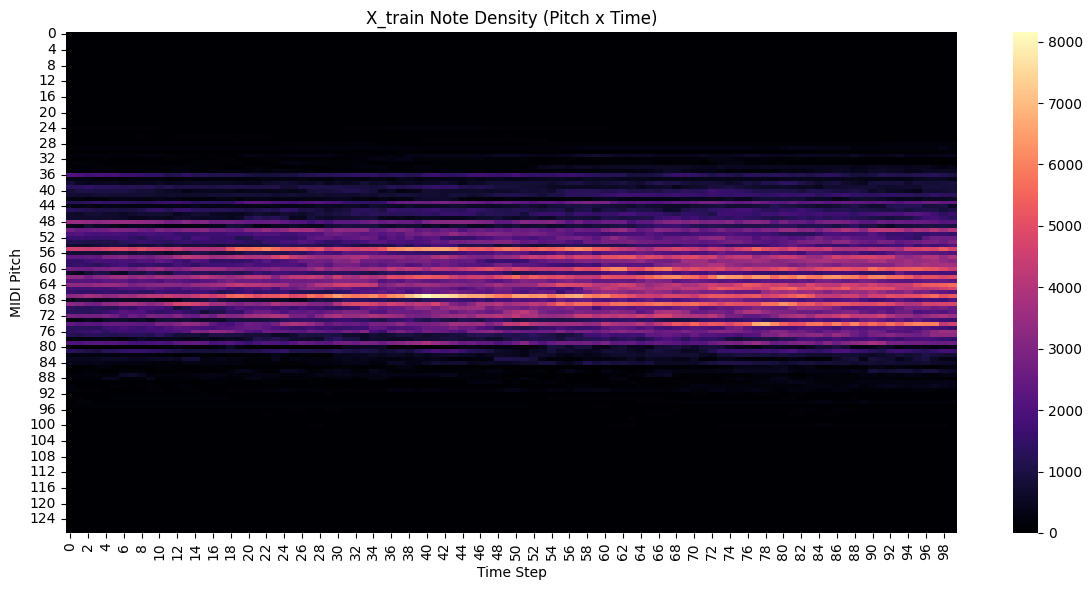

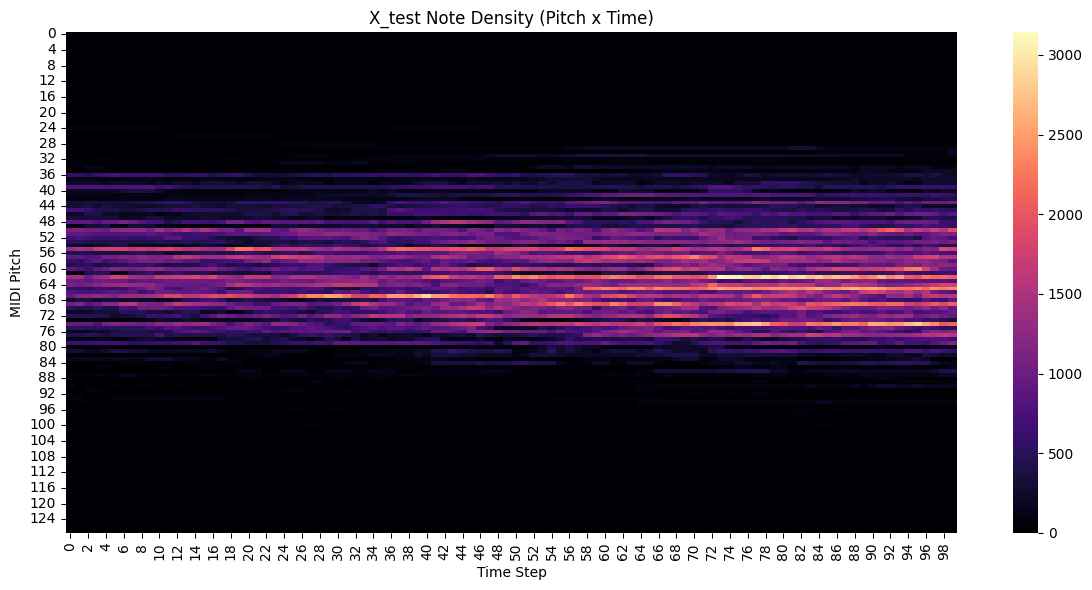

In [62]:
def plot_note_density(X, title="Note Density (Pitch x Time)"):
    # Combine all piano rolls into one big matrix
    combined = np.sum([x.squeeze() for x in X], axis=0)  # shape: (time_steps, pitches)
    plt.figure(figsize=(12, 6))
    sns.heatmap(combined.T, cmap="magma", cbar=True)
    plt.xlabel("Time Step")
    plt.ylabel("MIDI Pitch")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
plot_note_density(X_train, "X_train Note Density (Pitch x Time)")
plot_note_density(X_test,  "X_test Note Density (Pitch x Time)")

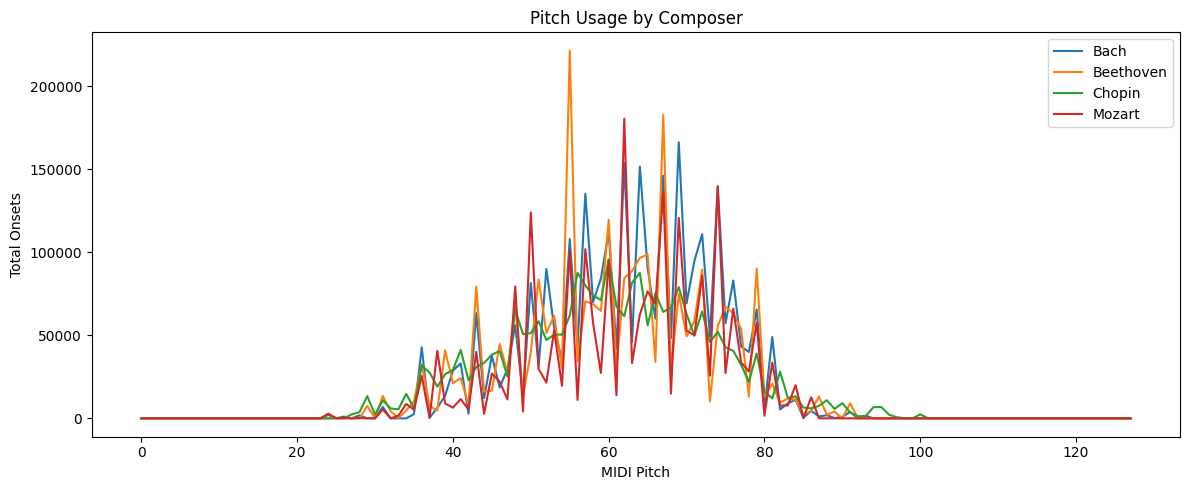

In [63]:
def plot_composer_pitch_profiles(X, y):
    composers = np.unique(y)
    pitch_profiles = {}

    for composer in composers:
        rolls = [x.squeeze() for x, label in zip(X, y) if label == composer]
        pitch_sum = np.sum(rolls, axis=(0, 1))  # total pitch usage
        pitch_profiles[composer] = pitch_sum

    plt.figure(figsize=(12, 5))
    for composer, profile in pitch_profiles.items():
        plt.plot(profile, label=composer)

    plt.xlabel("MIDI Pitch")
    plt.ylabel("Total Onsets")
    plt.title("Pitch Usage by Composer")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_composer_pitch_profiles(X_train, y_train)

## CNN Model Experimentation & Results
We used a type of artificial intelligence called a convolutional neural network to help identify which composer created a piece of music based on its digital piano notes. First, we cleaned and organized the files, then turned the music into a grid-like format that a computer can understand. We trained the model to learn patterns from these musical pieces and tested it to see how well it could recognize different composers. The final results included how accurate the model was and where it made mistakes, which we showed in a chart.

In [64]:
# Build a simple CNN model
# https://keras.io/guides/sequential_model/
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(X_train.shape[1], X_train.shape[2], 1)),  # conv layer 1
    MaxPooling2D((2, 2)),  # pooling 1
    Conv2D(64, (3, 3), activation="relu"),  # conv layer 2
    MaxPooling2D((2, 2)),  # pooling 2
    Flatten(),  # flatten to 1D
    Dense(64, activation="relu"),  # dense layer
    Dense(len(label_encoder.classes_), activation="softmax")])  # output layer, used softmax since we are using multiclass labels

# Using Adam optimizer for efficient training, categorical crossentropy for multiclass labels, and accuracy to track performance
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

#Train and add early_stop so I know it is improving

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
history = model.fit(
    X_train, y_train_enc,
    epochs=50,  #may be high, but find the stop usually only brings it out to about 10 anyway
    batch_size = 64,  #tried multiple and this seems to perform best
    validation_data=(X_test, y_test_enc), #maybe should also get validation data?
    callbacks=[early_stop],
    verbose=0)


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 98, 126, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 44160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,826,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,845,380 (10.85 MB)

 Trainable params: 2,845,380 (10.85 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Evaluate performance
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        48
   Beethoven       1.00      1.00      1.00        47
      Chopin       1.00      1.00      1.00        51
      Mozart       1.00      1.00      1.00        32

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



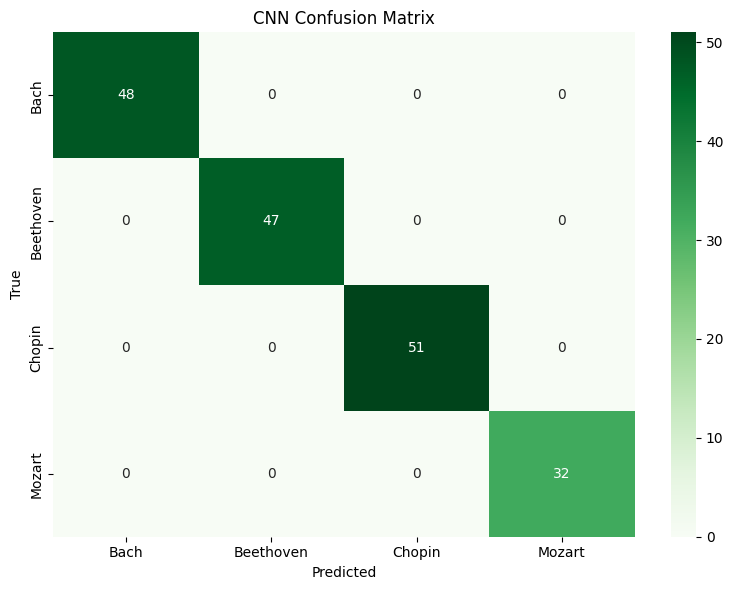

In [66]:
# Get performance metrics
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

# Save results for comparison later to the LSTM model
cnn_results = {
    "classification_report": report,
    "confusion_matrix": conf_matrix.tolist(),
    "classes": label_encoder.classes_.tolist()}

# Show classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Visualize confusion matrix in green
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,annot = True, cmap="Greens",  xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.tight_layout()
plt.show()

## LSTM Model Experimentation and Results

In [67]:
# Reshape piano rolls for LSTM (time_steps x features)
X_train_lstm = X_train.squeeze(-1)  # Shape becomes (samples, timesteps, features)
X_test_lstm = X_test.squeeze(-1)

In [68]:
model_LM = Sequential()

# First LSTM layer
model_LM.add(LSTM(units=128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False)) 
model_LM.add(BatchNormalization())
model_LM.add(Dropout(0.3))

# Fully connected layer
model_LM.add(Dense(64, activation='relu'))
model_LM.add(Dropout(0.3))

# Output layer
model_LM.add(Dense(4, activation='softmax'))

# Compile the model
model_LM.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Print summary
model_LM.summary()

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,612 (549.27 KB)

 Trainable params: 140,356 (548.27 KB)

 Non-trainable params: 256 (1.00 KB)

In [69]:
# Training
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model_LM.fit(
    X_train_lstm, y_train_enc,
    epochs=50,
    batch_size=64,
    validation_data=(X_test_lstm, y_test_enc),
    callbacks=[early_stop],
    verbose=0)

In [70]:
# Evaluate
y_pred_probs = model_LM.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Classification Report:
              precision    recall  f1-score   support

        Bach       1.00      1.00      1.00        48
   Beethoven       1.00      1.00      1.00        47
      Chopin       1.00      1.00      1.00        51
      Mozart       1.00      1.00      1.00        32

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



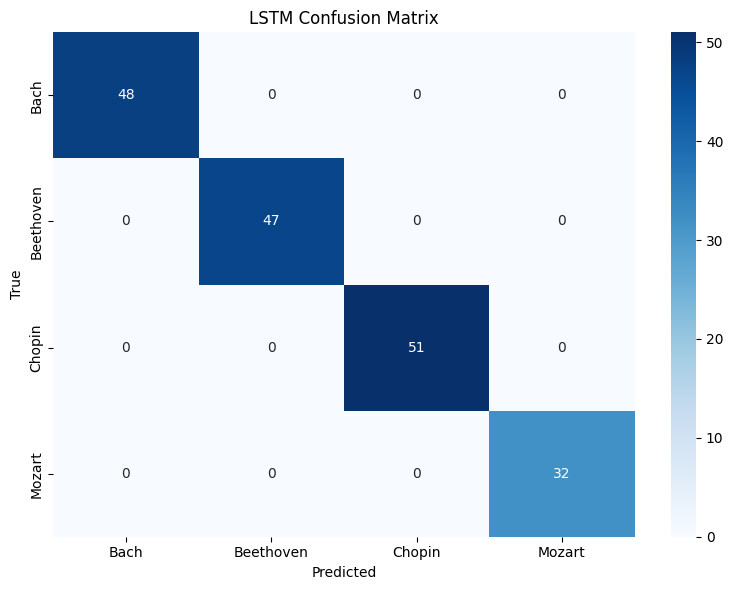

In [71]:

report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

lstm_results = {
    "classification_report": report,
    "confusion_matrix": conf_matrix.tolist(),
    "classes": label_encoder.classes_.tolist()}

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM Confusion Matrix")
plt.tight_layout()
plt.show()